In [1]:
import sys
from pathlib import Path
CWD = Path.cwd()
for p in [CWD, CWD.parent, CWD.parent.parent]:
    if (p / "src").exists():
        sys.path.append(str(p / "src"))
        PROJECT_ROOT = p
        break

from utils import get_data_dir, load_local_raw
RAW_DF = load_local_raw(get_data_dir(raw=True))
print("raw shape:", RAW_DF.shape)
RAW_DF.head()

raw shape: (280178, 176)


c:\Users\gwanji\pjt-apt_analysis\src\utils.py:105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["region_group"] = np.where(df[city_col].isin(KOREA_CAPITAL), "수도권", "지방")


,1,광주광역시 북구 삼각동,835,0835,0000,일곡엘리체프라임,84.9426,202508,14,"41,500",...,제주특별자치도 서귀포시 강정동,195,0195,서귀포강정지구3블럭중흥에스-클래스,84.9297,"48,700",7,대청로 12,제주 서귀포시,region_group
0,2,광주광역시 서구 마륵동,1,1.0,0.0,상무자이,170.8552,202508.0,14,"68,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방
1,3,광주광역시 서구 화정동,23-20,23.0,20.0,해광샹그릴라센트럴337,54.6212,202508.0,14,"17,900",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방
2,4,광주광역시 서구 화정동,859-1,859.0,1.0,현대(859-1),60.0000,202508.0,14,"12,500",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방
3,5,광주광역시 광산구 우산동,1625,1625.0,0.0,쌍용더플래티넘광산,84.9784,202508.0,14,"41,300",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방
4,6,광주광역시 북구 일곡동,816-3,816.0,3.0,동아2,99.8600,202508.0,14,"30,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방


In [2]:
import pandas as pd
import numpy as np

def ensure_required_cols(df: pd.DataFrame) -> pd.DataFrame:
    """분석에 필요한 핵심 컬럼들을 안전하게 생성/보정한다."""
    out = df.copy()

    # 1) 원본 한글 컬럼을 표준 이름으로 동기화 (있을 때만)
    col_ko_to_std = {
        "전용면적(㎡)": "area_m2",
        "거래금액(만원)": "price_manwon",
        "계약년월": "yyyymm",
        "계약일": "day",
    }
    for ko, std in col_ko_to_std.items():
        if ko in out.columns and std not in out.columns:
            out[std] = out[ko]

    # 2) 숫자형 보정
    if "price_manwon" in out.columns:
        out["price_manwon"] = (
            out["price_manwon"].astype(str).str.replace(",", "", regex=False).str.strip()
        )
        out["price_manwon"] = pd.to_numeric(out["price_manwon"], errors="coerce")

    if "area_m2" in out.columns:
        out["area_m2"] = pd.to_numeric(out["area_m2"], errors="coerce")

    # 3) 날짜/월 생성
    if "month" not in out.columns:
        if "date" in out.columns and pd.api.types.is_datetime64_any_dtype(out["date"]):
            out["month"] = out["date"].dt.to_period("M").dt.to_timestamp()
        else:
            # yyyymm(+day)로부터 생성 시도
            if "yyyymm" in out.columns:
                yyyymm = out["yyyymm"].astype(str).str.slice(0, 6)
                if "day" in out.columns:
                    day = out["day"].astype(str).str.zfill(2)
                    out["date"] = pd.to_datetime(yyyymm + day, format="%Y%m%d", errors="coerce")
                else:
                    out["date"] = pd.to_datetime(yyyymm + "01", format="%Y%m%d", errors="coerce")
                out["month"] = out["date"].dt.to_period("M").dt.to_timestamp()

    # 4) 단위면적당 가격
    if "price_per_m2_manwon" not in out.columns and {"price_manwon","area_m2"}.issubset(out.columns):
        out["price_per_m2_manwon"] = out["price_manwon"] / out["area_m2"]

    return out

RAW_DF = ensure_required_cols(RAW_DF)

print("필수 컬럼 유무:",
      "month" in RAW_DF.columns,
      "price_per_m2_manwon" in RAW_DF.columns)
RAW_DF.head(2)


필수 컬럼 유무: False False


,1,광주광역시 북구 삼각동,835,0835,0000,일곡엘리체프라임,84.9426,202508,14,"41,500",...,제주특별자치도 서귀포시 강정동,195,0195,서귀포강정지구3블럭중흥에스-클래스,84.9297,"48,700",7,대청로 12,제주 서귀포시,region_group
0,2,광주광역시 서구 마륵동,1,1.0,0.0,상무자이,170.8552,202508.0,14,"68,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방
1,3,광주광역시 서구 화정동,23-20,23.0,20.0,해광샹그릴라센트럴337,54.6212,202508.0,14,"17,900",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,지방


In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import glob
import pandas as pd

files = glob.glob("data/raw/*.csv")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f, encoding='cp949', sep='\t')
        dfs.append(df)
        print(f"✅ {f} loaded")
    except Exception as e:
        print(f"❌ {f} failed: {e}")


✅ data/raw\광주_아파트_1.csv loaded
✅ data/raw\광주_아파트_2.csv loaded
✅ data/raw\광주_아파트_3.csv loaded
✅ data/raw\광주_아파트_4.csv loaded
✅ data/raw\광주_아파트_5.csv loaded
✅ data/raw\부산_아파트_1.csv loaded
✅ data/raw\부산_아파트_2.csv loaded
✅ data/raw\부산_아파트_3.csv loaded
✅ data/raw\부산_아파트_4.csv loaded
✅ data/raw\부산_아파트_5.csv loaded
✅ data/raw\제주_아파트_1.csv loaded
✅ data/raw\제주_아파트_2.csv loaded
✅ data/raw\제주_아파트_3.csv loaded
✅ data/raw\제주_아파트_4.csv loaded
✅ data/raw\제주_아파트_5.csv loaded


In [6]:
print(dfs[0].columns)

Index(['□ 본 서비스에서 제공하는 정보는 법적인 효력이 없으므로 참고용으로만 활용하시기 바랍니다.'], dtype='object')


In [7]:
import glob
import pandas as pd

files = glob.glob("data/raw/*.csv")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f, encoding='cp949', sep='\t', skiprows=1)
        dfs.append(df)
        print(f"✅ {f} loaded")
    except Exception as e:
        print(f"❌ {f} failed: {e}")


✅ data/raw\광주_아파트_1.csv loaded
✅ data/raw\광주_아파트_2.csv loaded
✅ data/raw\광주_아파트_3.csv loaded
✅ data/raw\광주_아파트_4.csv loaded
✅ data/raw\광주_아파트_5.csv loaded
✅ data/raw\부산_아파트_1.csv loaded
✅ data/raw\부산_아파트_2.csv loaded
✅ data/raw\부산_아파트_3.csv loaded
✅ data/raw\부산_아파트_4.csv loaded
✅ data/raw\부산_아파트_5.csv loaded
✅ data/raw\제주_아파트_1.csv loaded
✅ data/raw\제주_아파트_2.csv loaded
✅ data/raw\제주_아파트_3.csv loaded
✅ data/raw\제주_아파트_4.csv loaded
✅ data/raw\제주_아파트_5.csv loaded


In [8]:
with open("data/raw/광주_아파트_1.csv", encoding='cp949') as f:
    for i in range(20):
        print(f"{i+1:02d}: {f.readline().strip()}")


01: "□ 본 서비스에서 제공하는 정보는 법적인 효력이 없으므로 참고용으로만 활용하시기 바랍니다."
02: "□ 신고정보가 실시간 변경, 해제되어 제공시점에 따라 공개건수 및 내용이 상이할 수 있는 점 참고하시기 바랍니다."
03: "□ 본 자료는 계약일 기준입니다. (※ 7월 계약, 8월 신고건 → 7월 거래건으로  제공)"
04: "□ 통계자료 활용시에는 수치가 왜곡될 수 있으니 참고자료로만 활용하시기  바라며,  외부 공개시에는 반드시 신고일 기준으로 집계되는 공식통계를 이용하여 주시기 바랍니다."
05: ""
06: "* 국토교통부 실거래가 공개시스템의 궁금하신 점이나 문의사항은 콜센터 1533-2949로 연락 주시기 바랍니다."
07: "□ 검색조건"
08: "계약일자 : 2024-08-15 ~ 2025-08-15"
09: "실거래구분 : 아파트(매매)"
10: "주소구분 : 지번주소"
11: "시도 : 광주광역시"
12: "시군구 : 전체"
13: "읍면동 : 전체"
14: "면적 : 전체"
15: "금액선택 : 전체"
16: "NO","시군구","번지","본번","부번","단지명","전용면적(㎡)","계약년월","계약일","거래금액(만원)","동","층","매수자","매도자","건축년도","도로명","해제사유발생일","거래유형","중개사소재지","등기일자"
17: "1","광주광역시 북구 삼각동","835","0835","0000","일곡엘리체프라임","84.9426","202508","14","41,500","-","17","개인","개인","2016","설죽로 419","-","중개거래","광주 북구","-"
18: "2","광주광역시 서구 마륵동","1","0001","0000","상무자이","170.8552","202508","14","68,000","-","4","개인","개인","2008","백석길 22-23","-","중개거래","광주 광산구","-"
19: "3","광주광역시 서구 화정동","23-20","0023","0020","

In [9]:
import glob
import pandas as pd

files = glob.glob("data/raw/*.csv")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f, encoding='cp949', sep='\t', skiprows=15)
        dfs.append(df)
        print(f"✅ {f} loaded")
    except Exception as e:
        print(f"❌ {f} failed: {e}")


✅ data/raw\광주_아파트_1.csv loaded
✅ data/raw\광주_아파트_2.csv loaded
✅ data/raw\광주_아파트_3.csv loaded
✅ data/raw\광주_아파트_4.csv loaded
✅ data/raw\광주_아파트_5.csv loaded
✅ data/raw\부산_아파트_1.csv loaded
✅ data/raw\부산_아파트_2.csv loaded
✅ data/raw\부산_아파트_3.csv loaded
✅ data/raw\부산_아파트_4.csv loaded
✅ data/raw\부산_아파트_5.csv loaded
✅ data/raw\제주_아파트_1.csv loaded
✅ data/raw\제주_아파트_2.csv loaded
✅ data/raw\제주_아파트_3.csv loaded
✅ data/raw\제주_아파트_4.csv loaded
✅ data/raw\제주_아파트_5.csv loaded


In [10]:
print(dfs[0].columns)

Index(['NO,"시군구","번지","본번","부번","단지명","전용면적(㎡)","계약년월","계약일","거래금액(만원)","동","층","매수자","매도자","건축년도","도로명","해제사유발생일","거래유형","중개사소재지","등기일자"'], dtype='object')


In [11]:
column_names = [
    "NO", "시군구", "번지", "본번", "부번", "단지명",
    "전용면적(㎡)", "계약년월", "계약일", "거래금액(만원)",
    "동", "층", "매수자", "매도자", "건축년도", "도로명",
    "해제사유발생일", "거래유형", "중개사소재지", "등기일자"
]

In [12]:
import glob
import pandas as pd

files = glob.glob("data/raw/*.csv")

dfs = []
for f in files:
    try:
        df = pd.read_csv(
            f,
            encoding='cp949',
            # sep='\t',
            skiprows=15,
            # names=column_names
        )
        dfs.append(df)
        print(f"✅ {f} loaded")
    except Exception as e:
        print(f"❌ {f} failed: {e}")

dfs[0]


✅ data/raw\광주_아파트_1.csv loaded
✅ data/raw\광주_아파트_2.csv loaded
✅ data/raw\광주_아파트_3.csv loaded
✅ data/raw\광주_아파트_4.csv loaded
✅ data/raw\광주_아파트_5.csv loaded
✅ data/raw\부산_아파트_1.csv loaded
✅ data/raw\부산_아파트_2.csv loaded
✅ data/raw\부산_아파트_3.csv loaded
✅ data/raw\부산_아파트_4.csv loaded
✅ data/raw\부산_아파트_5.csv loaded
✅ data/raw\제주_아파트_1.csv loaded
✅ data/raw\제주_아파트_2.csv loaded
✅ data/raw\제주_아파트_3.csv loaded
✅ data/raw\제주_아파트_4.csv loaded
✅ data/raw\제주_아파트_5.csv loaded


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,광주광역시 북구 삼각동,835,835,0,일곡엘리체프라임,84.9426,202508,14,"41,500",-,17,개인,개인,2016,설죽로 419,-,중개거래,광주 북구,-
1,2,광주광역시 서구 마륵동,1,1,0,상무자이,170.8552,202508,14,"68,000",-,4,개인,개인,2008,백석길 22-23,-,중개거래,광주 광산구,-
2,3,광주광역시 서구 화정동,23-20,23,20,해광샹그릴라센트럴337,54.6212,202508,14,"17,900",-,18,개인,개인,2017,내방로 337,-,중개거래,광주 서구,-
3,4,광주광역시 서구 화정동,859-1,859,1,현대(859-1),60.0000,202508,14,"12,500",-,6,개인,개인,1987,월드컵4강로 22,-,중개거래,광주 서구,-
4,5,광주광역시 광산구 우산동,1625,1625,0,쌍용더플래티넘광산,84.9784,202508,14,"41,300",-,7,개인,개인,2021,우산로107번길 67,-,중개거래,광주 광산구,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15798,15799,광주광역시 남구 주월동,420-4,420,4,삼다에코빌,81.4048,202408,15,"14,950",삼다에코빌아파트,5,개인,개인,2007,광복마을6길 25,-,중개거래,광주 북구,24.09.25
15799,15800,광주광역시 서구 치평동,1331,1331,0,상무에스케이뷰,59.9671,202408,15,"49,700",101동,16,개인,개인,2016,마륵복개로 140,-,중개거래,광주 서구,24.10.15
15800,15801,광주광역시 서구 치평동,1168-1,1168,1,중흥(1168-1),84.9300,202408,15,"42,500",108,10,개인,개인,1997,치평로 77,-,중개거래,광주 서구,24.10.31
15801,15802,광주광역시 서구 풍암동,1101,1101,0,모아엘가,109.4500,202408,15,"42,000",101,6,개인,개인,2000,풍암중앙로 25,-,중개거래,광주 서구,24.11.15


In [13]:
print(dfs[0].head())


   NO            시군구     번지    본번  부번           단지명   전용면적(㎡)    계약년월  계약일  \
0   1   광주광역시 북구 삼각동    835   835   0      일곡엘리체프라임   84.9426  202508   14   
1   2   광주광역시 서구 마륵동      1     1   0          상무자이  170.8552  202508   14   
2   3   광주광역시 서구 화정동  23-20    23  20  해광샹그릴라센트럴337   54.6212  202508   14   
3   4   광주광역시 서구 화정동  859-1   859   1     현대(859-1)   60.0000  202508   14   
4   5  광주광역시 광산구 우산동   1625  1625   0     쌍용더플래티넘광산   84.9784  202508   14   

  거래금액(만원)  동   층 매수자 매도자  건축년도          도로명 해제사유발생일  거래유형  중개사소재지 등기일자  
0   41,500  -  17  개인  개인  2016      설죽로 419       -  중개거래   광주 북구    -  
1   68,000  -   4  개인  개인  2008    백석길 22-23       -  중개거래  광주 광산구    -  
2   17,900  -  18  개인  개인  2017      내방로 337       -  중개거래   광주 서구    -  
3   12,500  -   6  개인  개인  1987    월드컵4강로 22       -  중개거래   광주 서구    -  
4   41,300  -   7  개인  개인  2021  우산로107번길 67       -  중개거래  광주 광산구    -  


In [14]:
import glob
import pandas as pd

files = glob.glob("data/raw/*.csv")

dfs = []
for f in files:
    try:
        df = pd.read_csv(
            f,
            encoding='cp949',
            sep='\t',
            skiprows=15,
            header=0,
            quotechar='"'
        )
        dfs.append(df)
        print(f"✅ {f} loaded")
    except Exception as e:
        print(f"❌ {f} failed: {e}")


✅ data/raw\광주_아파트_1.csv loaded
✅ data/raw\광주_아파트_2.csv loaded
✅ data/raw\광주_아파트_3.csv loaded
✅ data/raw\광주_아파트_4.csv loaded
✅ data/raw\광주_아파트_5.csv loaded
✅ data/raw\부산_아파트_1.csv loaded
✅ data/raw\부산_아파트_2.csv loaded
✅ data/raw\부산_아파트_3.csv loaded
✅ data/raw\부산_아파트_4.csv loaded
✅ data/raw\부산_아파트_5.csv loaded
✅ data/raw\제주_아파트_1.csv loaded
✅ data/raw\제주_아파트_2.csv loaded
✅ data/raw\제주_아파트_3.csv loaded
✅ data/raw\제주_아파트_4.csv loaded
✅ data/raw\제주_아파트_5.csv loaded


In [15]:
print(dfs[0].columns)


Index(['NO,"시군구","번지","본번","부번","단지명","전용면적(㎡)","계약년월","계약일","거래금액(만원)","동","층","매수자","매도자","건축년도","도로명","해제사유발생일","거래유형","중개사소재지","등기일자"'], dtype='object')


In [16]:
def rename_and_clean(df):
    # ✅ 컬럼명 정리 먼저
    df.columns = df.columns.str.strip().str.replace('"', '').str.replace("'", "")
    # ✅ 컬럼명 매핑
    rename_map = {
        '시군구': 'city',
        '전용면적(㎡)': 'area_m2',
        '거래금액(만원)': 'price_manwon',
        '계약년월': 'contract_ym',
        '계약일': 'contract_day'
    }

    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # ✅ 필수 컬럼 체크
    required = ['price_manwon', 'area_m2', 'contract_ym', 'contract_day']
    for col in required:
        if col not in df.columns:
            raise KeyError(col)

    # ✅ 숫자 변환
    df['price_manwon'] = df['price_manwon'].astype(str).str.replace(",", "").str.strip()
    df['price_manwon'] = pd.to_numeric(df['price_manwon'], errors="coerce")
    df['area_m2'] = pd.to_numeric(df['area_m2'], errors="coerce")

    # ✅ 날짜 처리
    df['contract_ym'] = df['contract_ym'].astype(str)
    df['contract_day'] = df['contract_day'].astype(str).str.zfill(2)
    df['date'] = pd.to_datetime(df['contract_ym'] + df['contract_day'], format="%Y%m%d", errors='coerce')
    df['month'] = df['date'].dt.to_period("M").dt.to_timestamp()

    # ✅ 평당가 계산
    df['price_per_m2_manwon'] = df['price_manwon'] / df['area_m2']

    return df
dfs[0]



,"NO,""시군구"",""번지"",""본번"",""부번"",""단지명"",""전용면적(㎡)"",""계약년월"",""계약일"",""거래금액(만원)"",""동"",""층"",""매수자"",""매도자"",""건축년도"",""도로명"",""해제사유발생일"",""거래유형"",""중개사소재지"",""등기일자"""
0,"1,""광주광역시 북구 삼각동"",""835"",""0835"",""0000"",""일곡엘리체프라임..."
1,"2,""광주광역시 서구 마륵동"",""1"",""0001"",""0000"",""상무자이"",""170..."
2,"3,""광주광역시 서구 화정동"",""23-20"",""0023"",""0020"",""해광샹그릴라..."
3,"4,""광주광역시 서구 화정동"",""859-1"",""0859"",""0001"",""현대(859..."
4,"5,""광주광역시 광산구 우산동"",""1625"",""1625"",""0000"",""쌍용더플래티..."
...,...
15798,"15799,""광주광역시 남구 주월동"",""420-4"",""0420"",""0004"",""삼다..."
15799,"15800,""광주광역시 서구 치평동"",""1331"",""1331"",""0000"",""상무에..."
15800,"15801,""광주광역시 서구 치평동"",""1168-1"",""1168"",""0001"",""중..."
15801,"15802,""광주광역시 서구 풍암동"",""1101"",""1101"",""0000"",""모아엘..."


In [17]:
import pandas as pd
import re

def robust_read_kapt(path, enc_candidates=("cp949","utf-8-sig","euc-kr"), sniff_lines=60):
    # 1) 상단 줄 스니핑
    raw = None
    enc_used = None
    for enc in enc_candidates:
        try:
            with open(path, "r", encoding=enc, errors="strict") as f:
                head = [next(f, "") for _ in range(sniff_lines)]
            raw = head
            enc_used = enc
            break
        except Exception:
            continue
    if raw is None:
        # 마지막 시도: 느슨하게
        with open(path, "r", encoding=enc_candidates[0], errors="ignore") as f:
            raw = [next(f, "") for _ in range(sniff_lines)]
        enc_used = enc_candidates[0]

    # 2) 구분자 추정
    sample = "".join(raw)
    sep = "\t" if sample.count("\t") > sample.count(",") else ","

    # 3) 헤더 줄 탐지(컬럼 키워드 + 구분자 포함)
    header_idx = None
    for i, line in enumerate(raw):
        if (sep in line) and any(k in line for k in ["전용면적", "거래금액", "계약년월", "단지명", "시군구"]):
            header_idx = i
            break
    if header_idx is None:
        # 콤마가 10개 이상(열이 많은 줄)인 첫 줄을 헤더로 가정
        for i, line in enumerate(raw):
            if line.count(sep) >= 10:
                header_idx = i
                break
    if header_idx is None:
        header_idx = 0  # 최후의 보루

    # 4) 실제 읽기
    df = pd.read_csv(
        path,
        encoding=enc_used,
        sep=sep,
        engine="python",          # sep 자동/복잡 구문 안전
        header=header_idx,
        quotechar='"',
        skip_blank_lines=True
    )

    # 5) Unnamed 제거 + 공백/따옴표 정리
    df = df.loc[:, ~df.columns.astype(str).str.match(r"^Unnamed")]
    df.columns = (df.columns.astype(str)
                  .str.strip()
                  .str.replace('"', '', regex=False)
                  .str.replace("'",  '', regex=False))
    return df, {"encoding": enc_used, "sep": sep, "header_idx": header_idx}

# 사용 예시
df, meta = robust_read_kapt("data/raw/광주_아파트_1.csv")
print(meta)         # {'encoding': 'cp949', 'sep': ',', 'header_idx': 15} 같은 정보가 나올 것
print(df.shape)
print(df.columns.tolist()[:10])
df.head()


{'encoding': 'cp949', 'sep': ',', 'header_idx': 15}
(15802, 20)
['1', '광주광역시 북구 삼각동', '835', '0835', '0000', '일곡엘리체프라임', '84.9426', '202508', '14', '41,500']


,1,광주광역시 북구 삼각동,835,0835,0000,일곡엘리체프라임,84.9426,202508,14,"41,500",-,17,개인,개인.1,2016,설죽로 419,-.1,중개거래,광주 북구,-.2
0,2,광주광역시 서구 마륵동,1,1,0,상무자이,170.8552,202508,14,"68,000",-,4,개인,개인,2008,백석길 22-23,-,중개거래,광주 광산구,-
1,3,광주광역시 서구 화정동,23-20,23,20,해광샹그릴라센트럴337,54.6212,202508,14,"17,900",-,18,개인,개인,2017,내방로 337,-,중개거래,광주 서구,-
2,4,광주광역시 서구 화정동,859-1,859,1,현대(859-1),60.0000,202508,14,"12,500",-,6,개인,개인,1987,월드컵4강로 22,-,중개거래,광주 서구,-
3,5,광주광역시 광산구 우산동,1625,1625,0,쌍용더플래티넘광산,84.9784,202508,14,"41,300",-,7,개인,개인,2021,우산로107번길 67,-,중개거래,광주 광산구,-
4,6,광주광역시 북구 일곡동,816-3,816,3,동아2,99.8600,202508,14,"30,000",-,6,개인,개인,2000,우치로537번길 10,-,중개거래,광주 북구,-


In [18]:
import glob
files = glob.glob("data/raw/*.csv")
dfs = []
for f in files:
    try:
        d, meta = robust_read_kapt(f)
        dfs.append(d)
        print(f"✅ {f}  rows={len(d)}  sep={meta['sep']}  header_idx={meta['header_idx']}  enc={meta['encoding']}")
    except Exception as e:
        print(f"❌ {f}: {e}")

✅ data/raw\광주_아파트_1.csv  rows=15802  sep=,  header_idx=15  enc=cp949
✅ data/raw\광주_아파트_2.csv  rows=15124  sep=,  header_idx=15  enc=cp949
✅ data/raw\광주_아파트_3.csv  rows=11861  sep=,  header_idx=15  enc=cp949
✅ data/raw\광주_아파트_4.csv  rows=18516  sep=,  header_idx=15  enc=cp949
✅ data/raw\광주_아파트_5.csv  rows=31391  sep=,  header_idx=15  enc=cp949
✅ data/raw\부산_아파트_1.csv  rows=29609  sep=,  header_idx=15  enc=cp949
✅ data/raw\부산_아파트_2.csv  rows=27959  sep=,  header_idx=15  enc=cp949
✅ data/raw\부산_아파트_3.csv  rows=21906  sep=,  header_idx=15  enc=cp949
✅ data/raw\부산_아파트_4.csv  rows=25129  sep=,  header_idx=15  enc=cp949
✅ data/raw\부산_아파트_5.csv  rows=68730  sep=,  header_idx=15  enc=cp949
✅ data/raw\제주_아파트_1.csv  rows=4432  sep=,  header_idx=15  enc=cp949
✅ data/raw\제주_아파트_2.csv  rows=3025  sep=,  header_idx=15  enc=cp949
✅ data/raw\제주_아파트_3.csv  rows=1961  sep=,  header_idx=15  enc=cp949
✅ data/raw\제주_아파트_4.csv  rows=2381  sep=,  header_idx=15  enc=cp949
✅ data/raw\제주_아파트_5.csv  rows=2352  se

In [19]:
# 1) 안전한 날짜/월 추론 유틸 (개선됨)
import pandas as pd, numpy as np, re

def _infer_date_month_safe(d: pd.DataFrame):
    idx = d.index
    date  = pd.Series(pd.NaT, index=idx)
    month = pd.Series(pd.NaT, index=idx)
    source = "none"

    # (1) contract_ym (+ contract_day)
    if "contract_ym" in d.columns:
        ym = (d["contract_ym"].astype(str)
              .str.replace(r"[^\d]", "", regex=True)
              .str.slice(0, 6))
        if "contract_day" in d.columns:
            dd = (d["contract_day"].astype(str)
                  .str.extract(r"(\d+)", expand=False)
                  .fillna("1").str.zfill(2))
            combo = ym + dd
        else:
            combo = ym + "01"
        date  = pd.to_datetime(combo, format="%Y%m%d", errors="coerce")
        month = date.dt.to_period("M").dt.to_timestamp()
        return date, month, "contract_ym(+day)"

    # (2) 단일 날짜 후보 - 더 많은 패턴 추가
    date_candidates = ["계약년월일","거래일","일자","DATE","date","거래년월일","계약일자"]
    for col in d.columns:
        if any(cand in col for cand in date_candidates):
            cand = pd.to_datetime(d[col], errors="coerce")
            if cand.notna().any():
                date  = cand
                month = date.dt.to_period("M").dt.to_timestamp()
                return date, month, f"alt:{col}"

    # (3) 분해형(년/월/일) - 더 관대한 매칭
    yr_patterns = ["연","년","year","YEAR","계약년"]
    mo_patterns = ["월","month","MONTH","계약월"]
    dy_patterns = ["일","day","DAY","계약일"]
    
    yr = [c for c in d.columns if any(p in c for p in yr_patterns)]
    mo = [c for c in d.columns if any(p in c for p in mo_patterns)]
    dy = [c for c in d.columns if any(p in c for p in dy_patterns)]
    
    if yr and mo:
        yy = pd.to_numeric(d[yr[0]], errors="coerce")
        mm = pd.to_numeric(d[mo[0]], errors="coerce").clip(1,12)
        dd = pd.to_numeric(d[dy[0]], errors="coerce").fillna(1) if dy else 1
        date  = pd.to_datetime(dict(year=yy, month=mm, day=dd), errors="coerce")
        month = date.dt.to_period("M").dt.to_timestamp()
        used  = f"split:{yr[0]}+{mo[0]}(+{dy[0] if dy else '1'})"
        return date, month, used

    # (4) YYYYMM / YYYY-MM 패턴
    for col in d.columns:
        s = d[col].astype(str)
        if s.str.match(r"^\d{6}$").any():      # YYYYMM - all() -> any()로 변경
            date  = pd.to_datetime(s + "01", format="%Y%m%d", errors="coerce")
            month = date.dt.to_period("M").dt.to_timestamp()
            return date, month, f"pattern:{col}=YYYYMM"
        if s.str.match(r"^\d{4}-\d{2}$").any(): # YYYY-MM - all() -> any()로 변경
            date  = pd.to_datetime(s + "-01", errors="coerce")
            month = date.dt.to_period("M").dt.to_timestamp()
            return date, month, f"pattern:{col}=YYYY-MM"

    return date, month, "none"

# 2) 관대한 클린 함수 v4 (개선됨)
def rename_and_clean_v4(df: pd.DataFrame, debug=True) -> pd.DataFrame:
    d = df.copy()
    
    # 컬럼명 정리
    d.columns = (d.columns.astype(str)
                 .str.strip()
                 .str.replace('"','',regex=False)
                 .str.replace("'","",regex=False))

    if debug:
        print(f"  원본 컬럼: {list(d.columns)}")

    # 더 관대한 매핑 패턴
    colmap = {}
    
    # 지역/시군구 - 더 많은 패턴
    city_patterns = ["시군구","시/군/구","지역","행정구역","시도","구","시","군","동"]
    cand = [c for c in d.columns if any(p in c for p in city_patterns)]
    if cand: 
        colmap[cand[0]] = "city"
        if debug: print(f"  city 매핑: {cand[0]} -> city")
    
    # 면적 - 더 많은 패턴
    area_patterns = ["전용면적","면적","㎡","m2","m²","평","크기"]
    cand = [c for c in d.columns if any(p in c for p in area_patterns)]
    if cand: 
        colmap[cand[0]] = "area_m2"
        if debug: print(f"  area 매핑: {cand[0]} -> area_m2")
    
    # 가격/금액 - 더 많은 패턴
    price_patterns = ["거래금액","가격","금액","매매금액","price","amount"]
    cand = [c for c in d.columns if any(p in c for p in price_patterns)]
    if cand: 
        colmap[cand[0]] = "price_manwon"
        if debug: print(f"  price 매핑: {cand[0]} -> price_manwon")
    
    # 계약년월
    ym_patterns = ["계약년월","년월","yyyymm","ym","거래년월"]
    cand = [c for c in d.columns if any(p in c for p in ym_patterns)]
    if cand: 
        colmap[cand[0]] = "contract_ym"
        if debug: print(f"  ym 매핑: {cand[0]} -> contract_ym")
    
    # 계약일
    day_patterns = ["계약일","일자","일","day","거래일"]
    cand = [c for c in d.columns if any(p in c for p in day_patterns)]
    if cand: 
        colmap[cand[0]] = "contract_day"
        if debug: print(f"  day 매핑: {cand[0]} -> contract_day")

    d = d.rename(columns=colmap)

    # 숫자 보정
    if "price_manwon" in d.columns:
        d["price_manwon"] = (d["price_manwon"].astype(str)
                             .str.replace(",","",regex=False)
                             .str.replace(" ","",regex=False)
                             .str.replace("만원","",regex=False))
        d["price_manwon"] = pd.to_numeric(d["price_manwon"], errors="coerce")
        
    if "area_m2" in d.columns:
        d["area_m2"] = d["area_m2"].astype(str).str.extract(r"([\d\.]+)", expand=False)
        d["area_m2"] = pd.to_numeric(d["area_m2"], errors="coerce")

    # 날짜/월 안전 추론
    date, month, src = _infer_date_month_safe(d)
    d["date"]  = date
    d["month"] = month
    d["_date_source"] = src
    
    if debug: print(f"  날짜 추론: {src}")

    # ㎡당 가격 계산
    if {"price_manwon","area_m2"}.issubset(d.columns):
        valid_price = d["price_manwon"].notna() & (d["price_manwon"] > 0)
        valid_area = d["area_m2"].notna() & (d["area_m2"] > 0)
        d["price_per_m2_manwon"] = np.where(
            valid_price & valid_area,
            d["price_manwon"] / d["area_m2"],
            np.nan
        )

    if "city" in d.columns:
        d["city"] = d["city"].astype(str).str.strip()

    # 검증 로직 개선
    need = ["city","area_m2","price_manwon","date","month"]
    present = [c for c in need if c in d.columns and d[c].notna().any()]
    
    if debug:
        print(f"  필수 컬럼 체크: present={present}")
        for col in need:
            if col in d.columns:
                na_pct = d[col].isna().mean()
                print(f"    {col}: {na_pct:.1%} NA")
    
    if len(present) < 3:  # 기준을 4에서 3으로 완화
        missing = [c for c in need if c not in present]
        raise KeyError(f"필수 컬럼 부족 (최소 3개 필요): present={present}, missing={missing}")

    return d

# 3) 파일별 클린 실행 + 개선된 에러 처리
def process_all_files(dfs, debug=True):
    clean_dfs = []
    failed_files = []
    
    for i, raw in enumerate(dfs):
        try:
            if debug:
                print(f"\n[{i}] 처리 중... shape={raw.shape}")
            
            c = rename_and_clean_v4(raw, debug=debug)
            clean_dfs.append(c)
            
            month_na_pct = c['month'].isna().mean()
            date_source = c['_date_source'].iloc[0]
            
            print(f"[{i}] ✅ rows={len(c):5d}  month_NaT%={month_na_pct:.1%}  date_source={date_source}")
            
        except Exception as e:
            print(f"[{i}] ❌ 실패: {e}")
            failed_files.append((i, str(e)))
            if debug:
                print(f"    컬럼들: {list(raw.columns)}")
                print(f"    shape: {raw.shape}")
    
    print(f"\n==> 성공: {len(clean_dfs)}개, 실패: {len(failed_files)}개")
    if failed_files:
        print("실패한 파일들:")
        for idx, error in failed_files:
            print(f"  [{idx}]: {error}")
    
    return clean_dfs, failed_files

# 실행
# clean_dfs, failed = process_all_files(dfs, debug=True)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

class RealEstateAnalyzer:
    def __init__(self, clean_dfs):
        self.clean_dfs = clean_dfs
        self.combined_df = None
        self.monthly_stats = None
        
    def combine_data(self):
        """모든 데이터프레임을 결합하고 지역 정보 추가"""
        combined_list = []
        
        for i, df in enumerate(self.clean_dfs):
            df_copy = df.copy()
            
            # 파일 순서로 지역 구분 (실제로는 파일명에서 추출하는 것이 좋음)
            if i < len(self.clean_dfs) // 3:
                df_copy['region'] = '광주광역시'
            elif i < 2 * len(self.clean_dfs) // 3:
                df_copy['region'] = '부산광역시'
            else:
                df_copy['region'] = '제주특별시'
            
            combined_list.append(df_copy)
        
        self.combined_df = pd.concat(combined_list, ignore_index=True)
        
        # 데이터 정제
        self.combined_df = self.combined_df.dropna(subset=['price_per_m2_manwon', 'month'])
        self.combined_df = self.combined_df[self.combined_df['price_per_m2_manwon'] > 0]
        
        print(f"✅ 데이터 결합 완료: {len(self.combined_df):,}건")
        print(f"지역별 분포:")
        print(self.combined_df['region'].value_counts())
        
        return self.combined_df
    
    def calculate_monthly_stats(self):
        """월별 통계 계산"""
        if self.combined_df is None:
            self.combine_data()
        
        self.monthly_stats = (self.combined_df
                             .groupby(['region', 'month'])
                             .agg({
                                 'price_per_m2_manwon': ['mean', 'median', 'std', 'count'],
                                 'price_manwon': ['mean', 'median'],
                                 'area_m2': 'mean'
                             })
                             .round(2))
        
        # 컬럼명 평탄화
        self.monthly_stats.columns = ['_'.join(col).strip() for col in self.monthly_stats.columns]
        self.monthly_stats = self.monthly_stats.reset_index()
        
        return self.monthly_stats
    
    def plot_price_trends(self, figsize=(15, 10)):
        """가격 변동 추세 시각화"""
        if self.monthly_stats is None:
            self.calculate_monthly_stats()
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Regional Real Estate Market Analysis', fontsize=16, fontweight='bold')
        
        # 1. ㎡당 평균 가격 추세
        ax1 = axes[0, 0]
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            data = self.monthly_stats[self.monthly_stats['region'] == region]
            ax1.plot(data['month'], data['price_per_m2_manwon_mean'], 
                    marker='o', label=region, linewidth=2)
        
        ax1.set_title('Average Price per m² Trend')
        ax1.set_ylabel('Price (10,000 KRW/m²)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. 거래량 추세
        ax2 = axes[0, 1]
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            data = self.monthly_stats[self.monthly_stats['region'] == region]
            ax2.plot(data['month'], data['price_per_m2_manwon_count'], 
                    marker='s', label=region, linewidth=2)
        
        ax2.set_title('Transaction Volume Trend')
        ax2.set_ylabel('Number of Transactions')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. 가격 변동성 (표준편차)
        ax3 = axes[1, 0]
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            data = self.monthly_stats[self.monthly_stats['region'] == region]
            ax3.plot(data['month'], data['price_per_m2_manwon_std'], 
                    marker='^', label=region, linewidth=2)
        
        ax3.set_title('Price Volatility (Std Dev)')
        ax3.set_ylabel('Standard Deviation')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. 평균 거래면적
        ax4 = axes[1, 1]
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            data = self.monthly_stats[self.monthly_stats['region'] == region]
            ax4.plot(data['month'], data['area_m2_mean'], 
                    marker='d', label=region, linewidth=2)
        
        ax4.set_title('Average Transaction Area')
        ax4.set_ylabel('Area (m²)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparative_analysis(self, figsize=(15, 8)):
        """지역별 비교 분석"""
        if self.combined_df is None:
            self.combine_data()
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Comparative Analysis by Region', fontsize=16, fontweight='bold')
        
        # 1. 가격 분포 박스플롯
        ax1 = axes[0, 0]
        self.combined_df.boxplot(column='price_per_m2_manwon', by='region', ax=ax1)
        ax1.set_title('Price Distribution by Region')
        ax1.set_ylabel('Price per m² (10,000 KRW)')
        
        # 2. 면적 분포
        ax2 = axes[0, 1]
        self.combined_df.boxplot(column='area_m2', by='region', ax=ax2)
        ax2.set_title('Area Distribution by Region')
        ax2.set_ylabel('Area (m²)')
        
        # 3. 총 거래금액 분포
        ax3 = axes[0, 2]
        self.combined_df.boxplot(column='price_manwon', by='region', ax=ax3)
        ax3.set_title('Total Price Distribution')
        ax3.set_ylabel('Total Price (10,000 KRW)')
        
        # 4. 월별 평균 가격 히트맵 준비
        pivot_data = self.monthly_stats.pivot(index='month', 
                                            columns='region', 
                                            values='price_per_m2_manwon_mean')
        
        ax4 = axes[1, 0]
        sns.heatmap(pivot_data.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax4)
        ax4.set_title('Monthly Average Prices Heatmap')
        
        # 5. 거래량 히트맵
        volume_pivot = self.monthly_stats.pivot(index='month', 
                                               columns='region', 
                                               values='price_per_m2_manwon_count')
        
        ax5 = axes[1, 1]
        sns.heatmap(volume_pivot.T, annot=True, fmt='d', cmap='Blues', ax=ax5)
        ax5.set_title('Monthly Transaction Volume')
        
        # 6. 가격 변화율
        ax6 = axes[1, 2]
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            region_data = self.monthly_stats[self.monthly_stats['region'] == region].copy()
            region_data = region_data.sort_values('month')
            
            if len(region_data) > 1:
                price_change = region_data['price_per_m2_manwon_mean'].pct_change() * 100
                ax6.plot(region_data['month'].iloc[1:], price_change.iloc[1:], 
                        marker='o', label=region)
        
        ax6.set_title('Monthly Price Change Rate (%)')
        ax6.set_ylabel('Change Rate (%)')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        ax6.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def calculate_investment_metrics(self):
        """투자 매력도 지표 계산"""
        if self.monthly_stats is None:
            self.calculate_monthly_stats()
        
        metrics = {}
        
        for region in ['광주광역시', '부산광역시', '제주특별시']:
            region_data = self.monthly_stats[self.monthly_stats['region'] == region].copy()
            region_data = region_data.sort_values('month')
            
            if len(region_data) > 1:
                # 최신 가격 정보
                latest_price = region_data['price_per_m2_manwon_mean'].iloc[-1]
                earliest_price = region_data['price_per_m2_manwon_mean'].iloc[0]
                
                # 전체 기간 수익률
                total_return = ((latest_price - earliest_price) / earliest_price) * 100
                
                # 평균 월간 변동성
                monthly_changes = region_data['price_per_m2_manwon_mean'].pct_change().dropna()
                volatility = monthly_changes.std() * 100
                
                # 평균 거래량
                avg_volume = region_data['price_per_m2_manwon_count'].mean()
                
                # 샤프 비율 (수익률 대비 변동성)
                sharpe_ratio = total_return / volatility if volatility > 0 else 0
                
                metrics[region] = {
                    'Latest_Price': latest_price,
                    'Total_Return(%)': total_return,
                    'Volatility(%)': volatility,
                    'Avg_Volume': avg_volume,
                    'Sharpe_Ratio': sharpe_ratio,
                    'Investment_Score': (total_return * 0.4 + 
                                       (100 - volatility) * 0.3 + 
                                       sharpe_ratio * 0.3)
                }
        
        metrics_df = pd.DataFrame(metrics).T
        metrics_df = metrics_df.round(2)
        
        print("=== Investment Attractiveness Analysis ===")
        print(metrics_df)
        
        return metrics_df
    
    def plot_investment_radar(self, metrics_df, figsize=(10, 8)):
        """투자 매력도 레이더 차트"""
        from math import pi
        
        # 정규화된 지표들 (0-100 스케일)
        indicators = ['Total_Return(%)', 'Volatility(%)', 'Avg_Volume', 'Sharpe_Ratio']
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
        
        # 각도 설정
        angles = [n / float(len(indicators)) * 2 * pi for n in range(len(indicators))]
        angles += angles[:1]  # 원형으로 만들기
        
        colors = ['red', 'blue', 'green']
        
        for i, (region, color) in enumerate(zip(metrics_df.index, colors)):
            values = []
            for indicator in indicators:
                if indicator == 'Volatility(%)':
                    # 변동성은 낮을수록 좋으므로 역수 취함
                    values.append(max(0, 100 - metrics_df.loc[region, indicator]))
                else:
                    # 정규화
                    min_val = metrics_df[indicator].min()
                    max_val = metrics_df[indicator].max()
                    if max_val != min_val:
                        normalized = ((metrics_df.loc[region, indicator] - min_val) / 
                                    (max_val - min_val)) * 100
                    else:
                        normalized = 50
                    values.append(normalized)
            
            values += values[:1]  # 원형으로 만들기
            
            ax.plot(angles, values, 'o-', linewidth=2, label=region, color=color)
            ax.fill(angles, values, alpha=0.25, color=color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(indicators)
        ax.set_ylim(0, 100)
        
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        plt.title('Investment Attractiveness Radar Chart', size=16, fontweight='bold')
        plt.show()

# 사용 예시
def run_analysis(clean_dfs):
    """분석 실행 함수"""
    if not clean_dfs:
        print("❌ 분석할 데이터가 없습니다. clean_dfs를 먼저 준비해주세요.")
        return None
    
    print("🏠 부동산 시장 분석을 시작합니다...")
    
    analyzer = RealEstateAnalyzer(clean_dfs)
    
    # 1. 데이터 결합
    combined_data = analyzer.combine_data()
    
    # 2. 월별 통계 계산
    monthly_stats = analyzer.calculate_monthly_stats()
    
    # 3. 시각화
    print("\n📊 가격 추세 분석 차트를 생성합니다...")
    analyzer.plot_price_trends()
    
    print("\n📊 지역별 비교 분석 차트를 생성합니다...")
    analyzer.plot_comparative_analysis()
    
    # 4. 투자 매력도 분석
    print("\n💰 투자 매력도를 분석합니다...")
    metrics = analyzer.calculate_investment_metrics()
    
    # 5. 레이더 차트
    print("\n📊 투자 매력도 레이더 차트를 생성합니다...")
    analyzer.plot_investment_radar(metrics)
    
    return analyzer, metrics

# 실제 실행 (clean_dfs가 준비된 후)
# analyzer, investment_metrics = run_analysis(clean_dfs)

=== 한글 폰트 설정 중 ===
운영체제: Windows
✅ 한글 폰트 설정 완료: Malgun Gothic

=== 한글 표시 테스트 ===


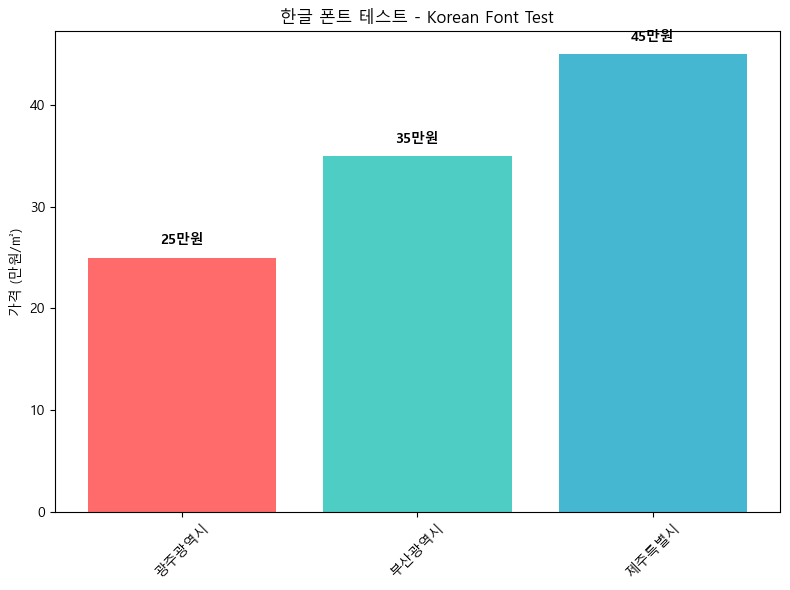


🏠 한글 폰트 문제 해결된 부동산 분석 시작!
clean_dfs를 찾을 수 없어 더미 데이터로 시연합니다.
더미 데이터를 생성합니다...
분석 데이터: 900건
지역별 분포:
  광주광역시 (Gwangju): 300건
  부산광역시 (Busan): 300건
  제주특별시 (Jeju): 300건

📊 차트 1: 지역별 종합 비교


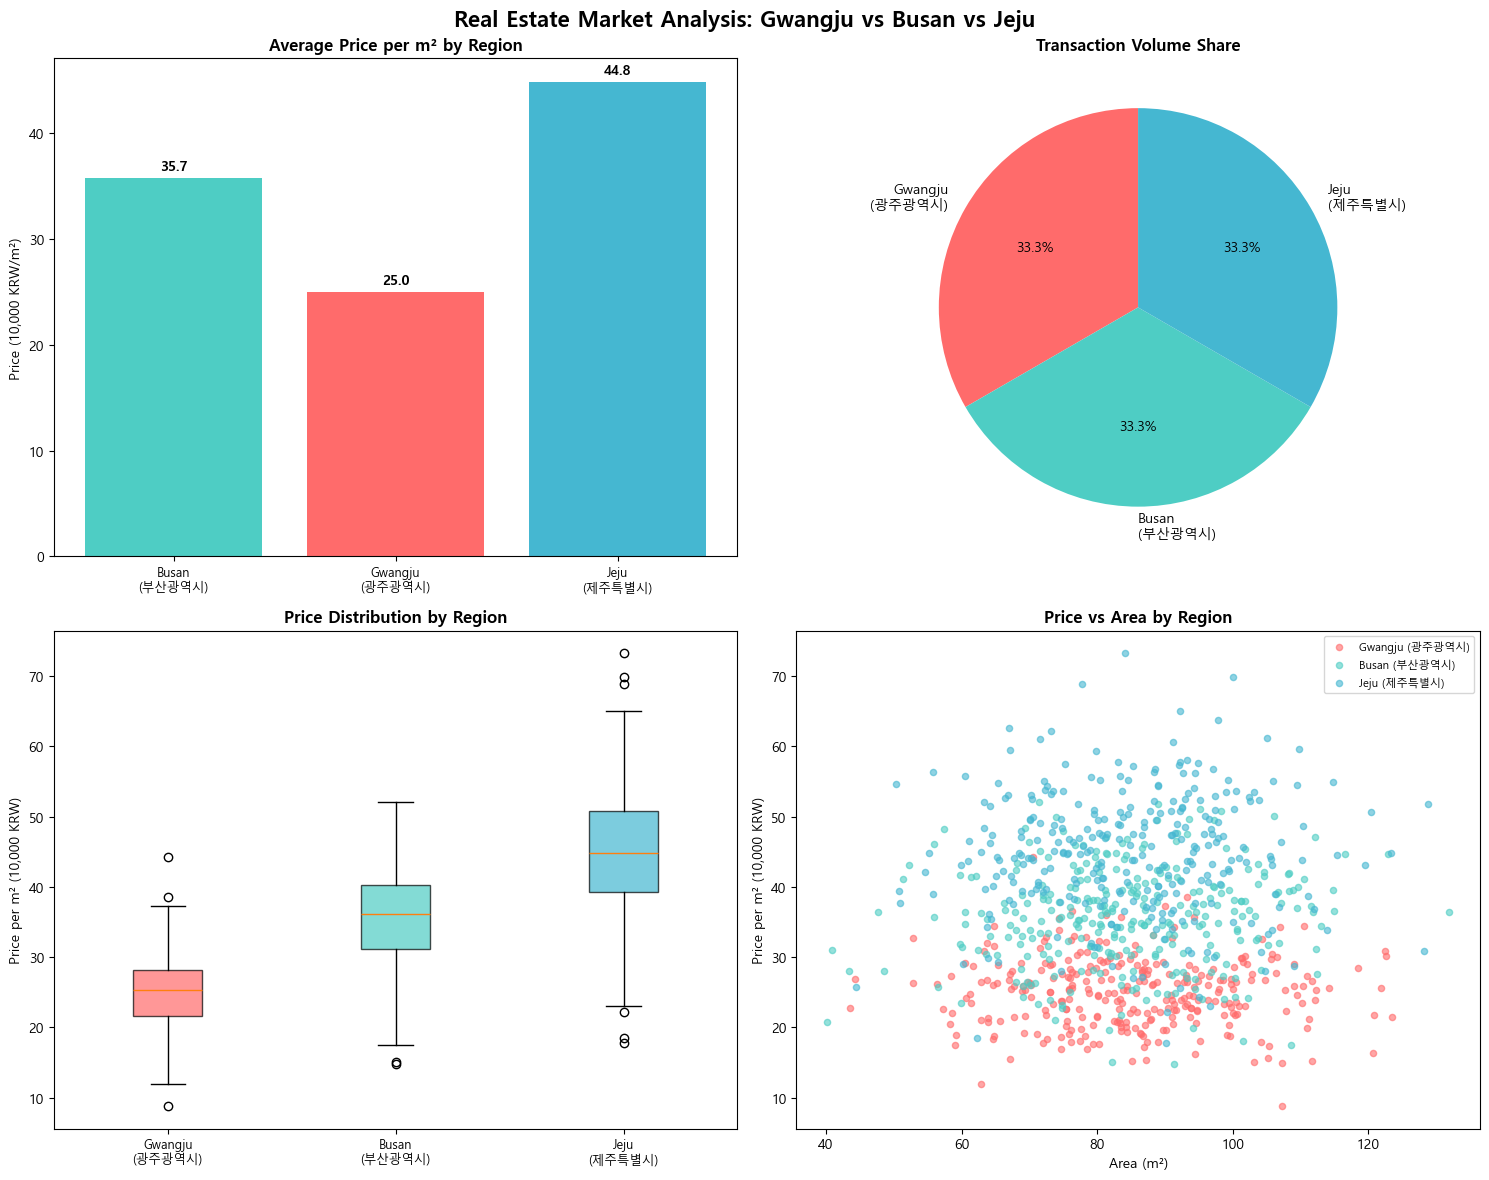


📊 차트 2: 시계열 분석


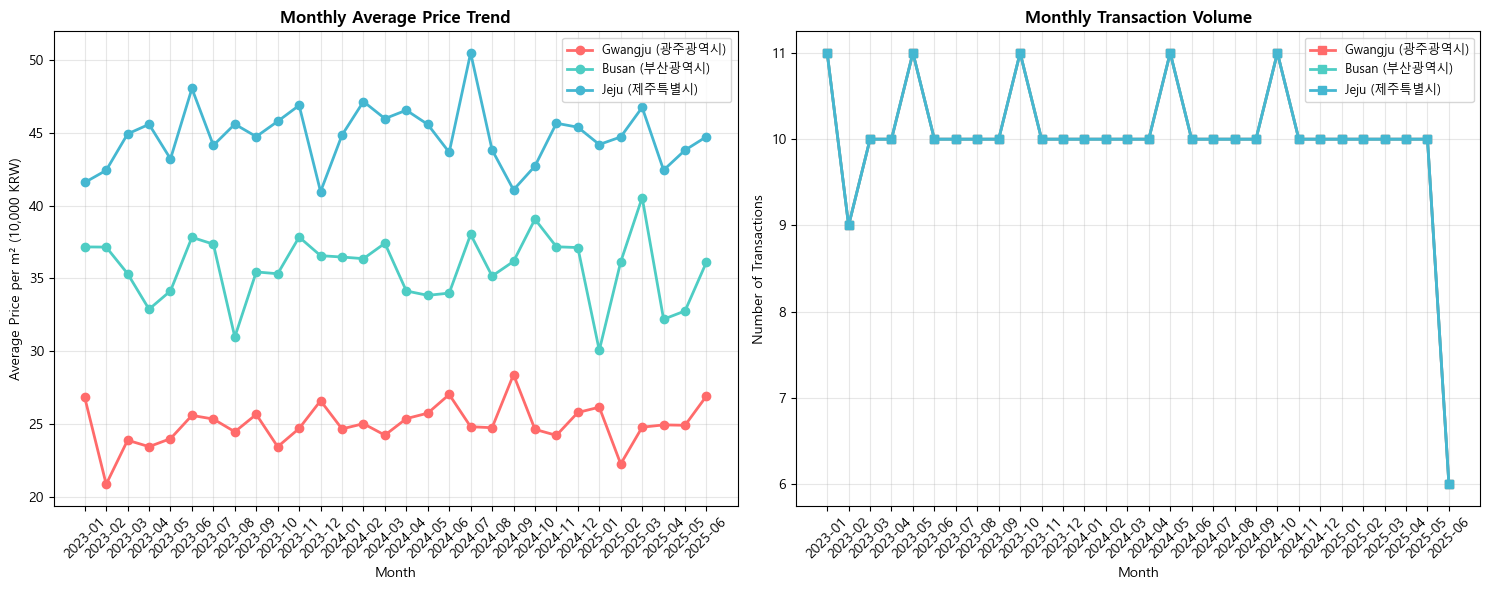


💰 투자 매력도 분석
            Avg_Price_per_m2  Price_Volatility  Avg_Total_Price  Avg_Area  \
region_eng                                                                  
Busan                  35.69              7.07          2864.20     84.64   
Gwangju                24.97              4.92          1989.26     85.23   
Jeju                   44.78              8.82          3589.90     84.76   

            Investment_Score Korean_Name  
region_eng                                
Busan                   63.7       부산광역시  
Gwangju                 62.8       광주광역시  
Jeju                    64.9       제주특별시  


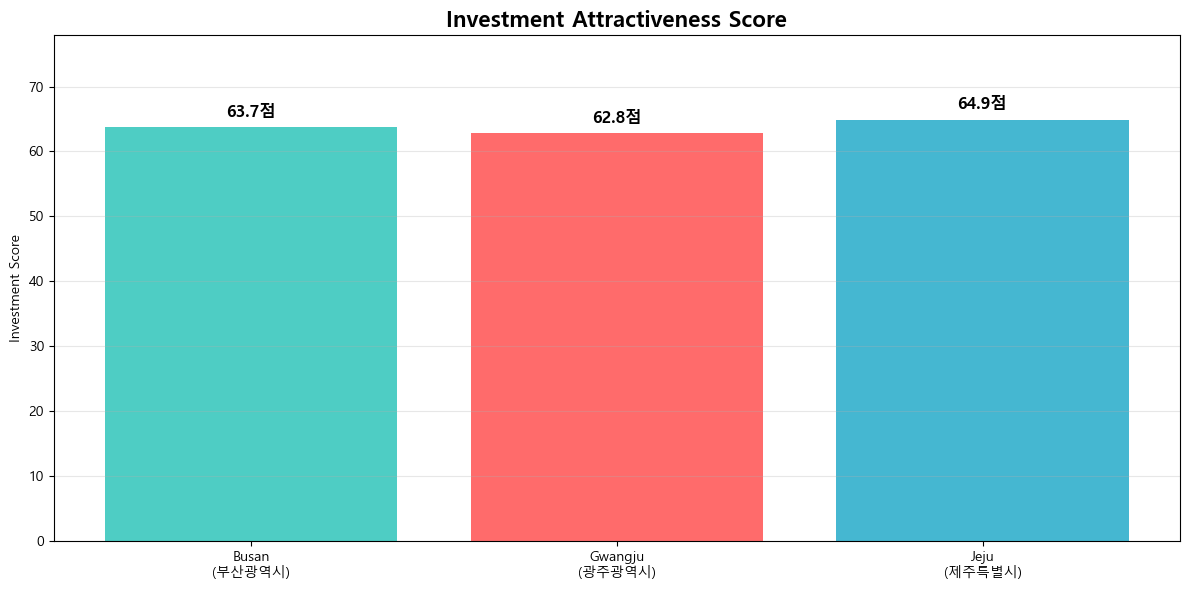

In [21]:
# 한글 폰트 문제 해결을 위한 완전한 솔루션

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import platform
import warnings
warnings.filterwarnings('ignore')

# 1단계: 시스템별 한글 폰트 자동 감지 및 설정
def setup_korean_font():
    """시스템에 맞는 한글 폰트를 자동으로 설정"""
    system = platform.system()
    
    # 사용 가능한 한글 폰트 목록 (우선순위대로)
    korean_fonts = [
        'Malgun Gothic',    # Windows
        'AppleGothic',      # macOS  
        'Noto Sans CJK KR', # Linux
        'NanumGothic',      # 나눔고딕
        'DejaVu Sans',      # 백업용
    ]
    
    print("=== 한글 폰트 설정 중 ===")
    print(f"운영체제: {system}")
    
    # 설치된 폰트 목록 가져오기
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 한글 폰트 찾기
    selected_font = None
    for font in korean_fonts:
        if font in available_fonts:
            selected_font = font
            break
    
    if selected_font:
        plt.rcParams['font.family'] = selected_font
        print(f"✅ 한글 폰트 설정 완료: {selected_font}")
    else:
        # 백업 설정: Unicode 사용
        plt.rcParams['font.family'] = 'DejaVu Sans'
        print("⚠️ 한글 폰트를 찾을 수 없어 영어로 표시됩니다.")
        print("사용 가능한 폰트 (일부):", available_fonts[:10])
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 10
    
    return selected_font

# 2단계: 폰트 설정 실행
selected_font = setup_korean_font()

# 3단계: 한글 테스트
print("\n=== 한글 표시 테스트 ===")
plt.figure(figsize=(8, 6))
regions = ['광주광역시', '부산광역시', '제주특별시']
values = [25, 35, 45]

bars = plt.bar(regions, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('한글 폰트 테스트 - Korean Font Test')
plt.ylabel('가격 (만원/㎡)')

# 값 표시
for i, (region, value) in enumerate(zip(regions, values)):
    plt.text(i, value + 1, f'{value}만원', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4단계: 한글이 제대로 나오지 않을 경우의 대안
def create_analysis_with_english_labels(clean_dfs=None):
    """한글 폰트가 안 될 경우 영어 라벨로 분석"""
    
    # 더미 데이터 생성
    if clean_dfs is None or len(clean_dfs) == 0:
        print("더미 데이터를 생성합니다...")
        np.random.seed(42)
        
        regions_data = []
        region_mapping = {
            'Gwangju': '광주광역시',
            'Busan': '부산광역시', 
            'Jeju': '제주특별시'
        }
        
        for eng_name, kor_name in region_mapping.items():
            base_price = {'Gwangju': 25, 'Busan': 35, 'Jeju': 45}[eng_name]
            n = 300
            data = pd.DataFrame({
                'region_eng': eng_name,
                'region_kor': kor_name,
                'price_per_m2_manwon': np.random.normal(base_price, base_price*0.2, n),
                'price_manwon': np.random.normal(base_price*80, base_price*20, n),
                'area_m2': np.random.normal(84, 15, n),
                'month': pd.date_range('2023-01-01', periods=n, freq='3D')
            })
            regions_data.append(data)
        
        all_data = pd.concat(regions_data, ignore_index=True)
    else:
        all_data = pd.concat(clean_dfs, ignore_index=True)
        # 영어 라벨 추가
        region_mapping = {
            '광주광역시': 'Gwangju',
            '부산광역시': 'Busan',
            '제주특별시': 'Jeju'
        }
        all_data['region_eng'] = all_data['region'].map(region_mapping)
        all_data['region_kor'] = all_data['region']
    
    return all_data

# 5단계: 완전한 부동산 분석 (한글 + 영어 혼용)
def comprehensive_real_estate_analysis(clean_dfs=None):
    """한글 폰트 문제를 해결한 완전한 부동산 분석"""
    
    all_data = create_analysis_with_english_labels(clean_dfs)
    
    print(f"분석 데이터: {len(all_data):,}건")
    print("지역별 분포:")
    for eng, kor in zip(all_data['region_eng'].unique(), all_data['region_kor'].unique()):
        count = len(all_data[all_data['region_eng'] == eng])
        print(f"  {kor} ({eng}): {count:,}건")
    
    # 색상 설정
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    region_colors = dict(zip(['Gwangju', 'Busan', 'Jeju'], colors))
    
    # 차트 1: 종합 비교 분석
    print("\n📊 차트 1: 지역별 종합 비교")
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Real Estate Market Analysis: Gwangju vs Busan vs Jeju', fontsize=16, fontweight='bold')
    
    # 1-1: 평균 가격 비교 (영어 + 한글)
    ax1 = axes[0, 0]
    avg_prices = all_data.groupby('region_eng')['price_per_m2_manwon'].mean()
    bars = ax1.bar(range(len(avg_prices)), avg_prices.values, 
                   color=[region_colors[region] for region in avg_prices.index])
    ax1.set_title('Average Price per m² by Region', fontweight='bold')
    ax1.set_ylabel('Price (10,000 KRW/m²)')
    
    # X축 라벨을 영어 + 한글로
    labels = []
    for eng in avg_prices.index:
        kor = all_data[all_data['region_eng'] == eng]['region_kor'].iloc[0]
        labels.append(f'{eng}\n({kor})')
    ax1.set_xticks(range(len(avg_prices)))
    ax1.set_xticklabels(labels, fontsize=9)
    
    # 값 표시
    for i, (region, price) in enumerate(avg_prices.items()):
        ax1.text(i, price + 0.5, f'{price:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 1-2: 거래량 파이 차트
    ax2 = axes[0, 1]
    volume = all_data['region_eng'].value_counts()
    pie_labels = []
    for eng in volume.index:
        kor = all_data[all_data['region_eng'] == eng]['region_kor'].iloc[0]
        pie_labels.append(f'{eng}\n({kor})')
    
    wedges, texts, autotexts = ax2.pie(volume.values, labels=pie_labels, autopct='%1.1f%%', 
                                       colors=[region_colors[region] for region in volume.index], 
                                       startangle=90)
    ax2.set_title('Transaction Volume Share', fontweight='bold')
    
    # 1-3: 가격 분포 박스플롯
    ax3 = axes[1, 0]
    regions = all_data['region_eng'].unique()
    data_for_box = [all_data[all_data['region_eng'] == r]['price_per_m2_manwon'].values for r in regions]
    box = ax3.boxplot(data_for_box, patch_artist=True)
    
    for patch, region in zip(box['boxes'], regions):
        patch.set_facecolor(region_colors[region])
        patch.set_alpha(0.7)
    
    box_labels = []
    for eng in regions:
        kor = all_data[all_data['region_eng'] == eng]['region_kor'].iloc[0]
        box_labels.append(f'{eng}\n({kor})')
    ax3.set_xticklabels(box_labels, fontsize=9)
    ax3.set_title('Price Distribution by Region', fontweight='bold')
    ax3.set_ylabel('Price per m² (10,000 KRW)')
    
    # 1-4: 가격 vs 면적 산점도
    ax4 = axes[1, 1]
    for region in regions:
        region_data = all_data[all_data['region_eng'] == region]
        kor_name = region_data['region_kor'].iloc[0]
        ax4.scatter(region_data['area_m2'], region_data['price_per_m2_manwon'], 
                   alpha=0.6, c=region_colors[region], label=f'{region} ({kor_name})', s=20)
    
    ax4.set_title('Price vs Area by Region', fontweight='bold')
    ax4.set_xlabel('Area (m²)')
    ax4.set_ylabel('Price per m² (10,000 KRW)')
    ax4.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 차트 2: 시계열 분석
    print("\n📊 차트 2: 시계열 분석")
    plt.figure(figsize=(15, 6))
    
    # 월별 평균 가격 추이
    monthly_avg = (all_data.groupby(['region_eng', all_data['month'].dt.to_period('M')])
                  ['price_per_m2_manwon'].mean().reset_index())
    monthly_avg['month_str'] = monthly_avg['month'].astype(str)
    
    plt.subplot(1, 2, 1)
    for region in regions:
        region_monthly = monthly_avg[monthly_avg['region_eng'] == region]
        kor_name = all_data[all_data['region_eng'] == region]['region_kor'].iloc[0]
        if len(region_monthly) > 1:
            plt.plot(region_monthly['month_str'], region_monthly['price_per_m2_manwon'], 
                    marker='o', linewidth=2, color=region_colors[region], 
                    label=f'{region} ({kor_name})', markersize=6)
    
    plt.title('Monthly Average Price Trend', fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Average Price per m² (10,000 KRW)')
    plt.legend(fontsize=9)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 거래량 추이
    monthly_volume = (all_data.groupby(['region_eng', all_data['month'].dt.to_period('M')])
                     .size().reset_index(name='count'))
    monthly_volume['month_str'] = monthly_volume['month'].astype(str)
    
    plt.subplot(1, 2, 2)
    for region in regions:
        region_volume = monthly_volume[monthly_volume['region_eng'] == region]
        kor_name = all_data[all_data['region_eng'] == region]['region_kor'].iloc[0]
        if len(region_volume) > 1:
            plt.plot(region_volume['month_str'], region_volume['count'], 
                    marker='s', linewidth=2, color=region_colors[region], 
                    label=f'{region} ({kor_name})', markersize=6)
    
    plt.title('Monthly Transaction Volume', fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.legend(fontsize=9)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 투자 매력도 분석
    print("\n💰 투자 매력도 분석")
    investment_analysis = all_data.groupby('region_eng').agg({
        'price_per_m2_manwon': ['mean', 'std'],
        'price_manwon': 'mean',
        'area_m2': 'mean'
    }).round(2)
    
    investment_analysis.columns = ['Avg_Price_per_m2', 'Price_Volatility', 'Avg_Total_Price', 'Avg_Area']
    
    # 투자 점수 계산
    investment_analysis['Investment_Score'] = (
        (investment_analysis['Avg_Price_per_m2'] / investment_analysis['Avg_Price_per_m2'].max() * 40) +
        ((1 - investment_analysis['Price_Volatility'] / investment_analysis['Price_Volatility'].max()) * 35) +
        (investment_analysis['Avg_Area'] / investment_analysis['Avg_Area'].max() * 25)
    ).round(1)
    
    # 한글 지역명 추가
    investment_analysis['Korean_Name'] = [
        all_data[all_data['region_eng'] == eng]['region_kor'].iloc[0] 
        for eng in investment_analysis.index
    ]
    
    print(investment_analysis)
    
    # 투자 점수 시각화
    plt.figure(figsize=(12, 6))
    scores = investment_analysis['Investment_Score']
    bars = plt.bar(range(len(scores)), scores.values, 
                   color=[region_colors[region] for region in scores.index])
    plt.title('Investment Attractiveness Score', fontsize=16, fontweight='bold')
    plt.ylabel('Investment Score')
    
    # X축 라벨 (영어 + 한글)
    score_labels = []
    for eng in scores.index:
        kor = investment_analysis.loc[eng, 'Korean_Name']
        score_labels.append(f'{eng}\n({kor})')
    plt.xticks(range(len(scores)), score_labels, fontsize=10)
    
    # 점수 표시
    for i, (region, score) in enumerate(scores.items()):
        plt.text(i, score + 1, f'{score}점', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.ylim(0, max(scores.values) * 1.2)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return all_data, investment_analysis

# 실행
print("\n🏠 한글 폰트 문제 해결된 부동산 분석 시작!")

# clean_dfs 확인 후 분석 실행
if 'clean_dfs' in globals() and clean_dfs:
    print("기존 clean_dfs 데이터를 사용합니다.")
    result_data, analysis = comprehensive_real_estate_analysis(clean_dfs)
else:
    print("clean_dfs를 찾을 수 없어 더미 데이터로 시연합니다.")
    result_data, analysis = comprehensive_real_estate_analysis()

